
# Group analysis with MNE


The aim of this lecture is to show you how to do group analysis
with MNE-Python.

    Authors: Britta Westner, Alexandre Gramfort, Denis A. Engemann, Mainak Jas, Hicham Janati

    License: BSD (3-clause)
   
The code in this notebook is taken from https://github.com/mne-tools/mne-biomag-group-demo/tree/master/scripts/results/statistics

You'll need to [download the data from here](https://www.dropbox.com/s/eh8yexs8d5fx3kp/ds000117-mne-group.zip?dl=0)

In [1]:
%matplotlib qt
import matplotlib.pyplot as plt

import os
import numpy as np
import mne

mne.set_log_level('error')
# Change the following path to where the folder ds000117-practical is on your disk
extra_path = os.path.expanduser('~/Documents/teaching/practical_meeg_2022_data/extra_data_mne')
evokeds_path = os.path.join(extra_path, 'group_analysis/')

Let's check if this worked:

In [2]:
ls $evokeds_path

sub-01_list-ave.fif  sub-04_list-ave.fif  sub-08_list-ave.fif
sub-02_list-ave.fif  sub-06_list-ave.fif  sub-09_list-ave.fif
sub-03_list-ave.fif  sub-07_list-ave.fif  sub-11_list-ave.fif


## Subjects

We have here the evoked data for all but 3 subjects.

In [3]:
datasets = ['sub-%02d' % ii for ii in range(1, 12)  if ii not in [5, 10, 16]]
datasets

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-11']

## Let's first look at our different datasets

In [26]:
subject = 'sub-02'
fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
evokeds = mne.read_evokeds(fname, verbose=False)
evokeds

[<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
 <Evoked | 'unfamiliar' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
 <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>]

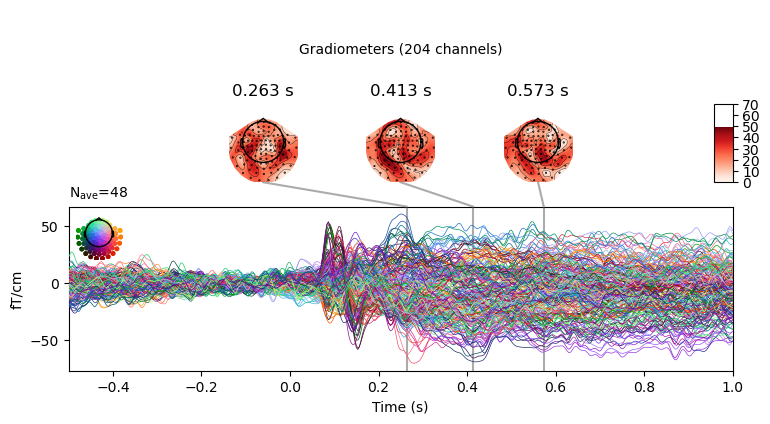

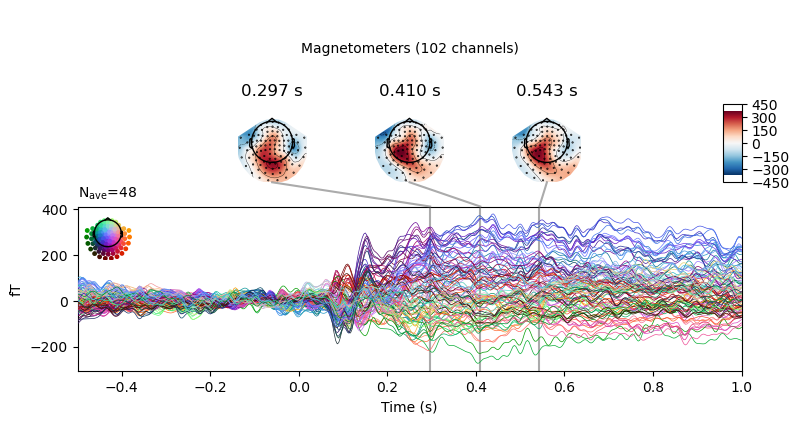

In [27]:
%matplotlib inline
evokeds[0].plot_joint();

We can now loop over all subjects to see if there are any subject
that look problematic.

In [4]:
conditions = ['famous', 'unfamiliar', 'scrambled']

f, axes = plt.subplots(4, 4, figsize=(13, 9), sharex=True, sharey=True)

for ax, subject in zip(axes.ravel(), datasets):
    evokeds_dict = dict()
    fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
    evokeds = mne.read_evokeds(fname)
    evokeds = [ev for ev in evokeds if ev.comment in conditions]
    for condition, ev in zip(conditions, evokeds):
        evokeds_dict[condition] = ev.crop(tmax=0.5)
    mne.viz.plot_compare_evokeds(evokeds_dict, picks='grad', show=False,
                                 axes=ax, title=subject)

plt.tight_layout()

<div class='alert alert-success'>
    <b>EXERCISE</b>:
     <ul>
      <li>Compute the same type of GFP plots for EEG and MEG Magnetometers</li>
      <li>Do you see any problematic subject?</li>
    </ul>
</div>

<div class='alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Read all the evoked data from all subjects and store the ones for conditions 'faces' or 'scrambled' in a Python list.</li>
      <li>Do a GFP plots of the contrast between "faces" vs "scrambled conditions. You will store the contrast of all subjects in a list.</li>
    </ul>
</div>

In [28]:
# TODO
evokeds_list = []

for subject in datasets:
    fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
    evokeds = mne.read_evokeds(fname)
    evokeds = [ev for ev in evokeds if ev.comment in ['unfamiliar', 'scrambled']]
    evokeds_list.append(evokeds)

evokeds_list

[[<Evoked | 'unfamiliar' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=50), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'unfamiliar' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'unfamiliar' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=45), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'unfamiliar' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'unfamiliar' (average, N=48), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'unfamiliar' (aver

In [8]:
evokeds_list

[[<Evoked | 'famous' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=50), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'famous' (average, N=50), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=45), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'famous' (average, N=44), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>,
  <Evoked | 'scrambled' (average, N=47), -0.5 – 1 sec, baseline -0.2 – 0 sec, 306 ch, ~8.0 MB>],
 [<Evoked | 'famous' (average, N=49), -0.5 – 1 sec

In [29]:
# TODO

contrast_list = []
f, axes = plt.subplots(4, 4, figsize=(13, 9), sharex=True, sharey=True)

for ax, subject, evokeds in zip(axes.ravel(), datasets, evokeds_list):
    contrast = mne.combine_evoked(evokeds, weights=[0.5, -0.5])
    contrast.crop(None, 0.5)
    contrast.comment = 'contrast'
    contrast_list.append(contrast)
    mne.viz.plot_compare_evokeds(contrast, picks='grad', show=False,
                                 axes=ax, title=subject)
plt.tight_layout()

In [11]:
contrast_list

[<Evoked | 'contrast' (average, N=98.98989898989899), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=96.9896907216495), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=94.73684210526315), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=90.9010989010989), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=94.98947368421052), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=98.00000000000001), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=95.95833333333334), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=94.0), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=98.00000000000001), -0.5 – 0.5 sec, baseline -0.2 – 0 sec, 306 ch, ~7.7 MB>]

### Look at grand averages

Grand averages are obtained by averaging the sensor space data.

In [10]:
mne.grand_average?

Signature: mne.grand_average(all_inst, interpolate_bads=True, drop_bads=True)
Docstring:
Make grand average of a list of Evoked or AverageTFR data.

For :class:`mne.Evoked` data, the function interpolates bad channels based
on the ``interpolate_bads`` parameter. If ``interpolate_bads`` is True,
the grand average file will contain good channels and the bad channels
interpolated from the good MEG/EEG channels.
For :class:`mne.time_frequency.AverageTFR` data, the function takes the
subset of channels not marked as bad in any of the instances.

The ``grand_average.nave`` attribute will be equal to the number
of evoked datasets used to calculate the grand average.

.. note:: A grand average evoked should not be used for source
          localization.

Parameters
----------
all_inst : list of Evoked or AverageTFR
    The evoked datasets.
interpolate_bads : bool
    If True, bad MEG and EEG channels are interpolated. Ignored for
    AverageTFR.
drop_bads : bool
    If True, drop all bad chann

In [30]:
evoked_gave = mne.grand_average(contrast_list)
evoked_gave.plot_joint();

## Let's do some statistics

We'll start with a single channel MEG2741

In [31]:
from scipy import stats
from mne.stats import permutation_cluster_1samp_test

n_jobs = 2  # nb of parallel jobs

channel = 'MEG1923'
idx = contrast.ch_names.index(channel)
data = np.array([c.data[idx] for c in contrast_list])

n_permutations = 5000  # number of permutations to run

# set initial threshold
p_initial = 0.05

adjacency = None
tail = 0.  # for two sided test

# set cluster threshold
n_samples = len(data)
threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
if np.sign(tail) < 0:
    threshold = -threshold

cluster_stats = permutation_cluster_1samp_test(
    data, threshold=threshold, n_jobs=n_jobs, verbose=True, tail=tail,
    step_down_p=0.05, adjacency=adjacency,
    n_permutations=n_permutations, seed=42)

T_obs, clusters, cluster_p_values, _ = cluster_stats

stat_fun(H1): min=-3.260935 max=1.835430
Running initial clustering …
Found 3 clusters


  0%|          | Permuting (exact test) : 0/255 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


In [32]:
cluster_p_values

array([0.92578125, 0.90234375, 0.453125  ])

#### Visualize results

In [33]:
times = 1e3 * contrast.times

fig, axes = plt.subplots(2, sharex=True)
ax = axes[0]
ax.plot(times, data.mean(axis=0), label='ERP Contrast')
ax.set(title='Channel : ' + channel, ylabel='fT/cm')
ax.legend()

ax = axes[1]
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] < p_thresh:
        h1 = ax.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
hf = ax.plot(times, T_obs, 'g')
ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1)
ax.set(xlabel='Time (ms)', ylabel='T-values',
       ylim=[-10., 10.], xlim=contrast.times[[0, -1]] * 1000)
fig.tight_layout(pad=0.5)
plt.show()

NameError: name 'h1' is not defined

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Do a cluster level stats in sensor space.</li>
    </ul>
</div>

In [39]:
# Assemble the data and run the cluster stats on channel data
data = np.array([c.copy().pick_types(meg='grad').crop(None, 0.8).data
                 for c in contrast_list])

adjacency = None
tail = 0.  # for two sided test

# set cluster threshold
p_thresh = 0.05 / (1 + (tail == 0))
n_samples = len(data)
threshold = -stats.t.ppf(p_thresh, n_samples - 1)
if np.sign(tail) < 0:
    threshold = -threshold

# Make a triangulation between EEG channels locations to
# use as connectivity for cluster level stat
adjacency = mne.channels.find_ch_adjacency(contrast.info, 'grad')[0]

data = np.transpose(data, (0, 2, 1))  # transpose for clustering

cluster_stats = permutation_cluster_1samp_test(
    data, threshold=threshold, n_jobs=2, verbose=True, tail=1,
    adjacency=adjacency, out_type='indices',
    check_disjoint=True, step_down_p=0.05, seed=42)

T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < 0.05)[0]

print("Good clusters: %i" % len(good_cluster_inds))

stat_fun(H1): min=-9.666747 max=10.696559
No disjoint adjacency sets found
Running initial clustering …
Found 238 clusters


  0%|          | Permuting (exact test) : 0/511 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting (exact test) : 0/511 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Good clusters: 1


In [38]:
p_values[np.where(p_values < 0.05)]

array([0.015625])

#### Visualize the spatio-temporal clusters

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap

times = contrast.times * 1e3
colors = 'r', 'steelblue'
linestyles = '-', '--'

pos = mne.find_layout(contrast.info).pos

T_obs_max = 5.
T_obs_min = -T_obs_max

# loop over significant clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):

    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for T0 stat
    T_obs_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at significant sensors
    signals = data[..., ch_inds].mean(axis=-1)
    sig_times = times[time_inds]

    # create spatial mask
    mask = np.zeros((T_obs_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(7, 2.))

    # plot average test statistic and mark significant sensors
    image, _ = plot_topomap(T_obs_map, pos, mask=mask, axes=ax_topo,
                            vmin=T_obs_min, vmax=T_obs_max,
                            show=False)

    # advanced matplotlib for showing image with figure and colorbar
    # in one plot
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar, format='%0.1f')
    ax_topo.set_xlabel('Averaged t-map\n({:0.1f} - {:0.1f} ms)'.format(
        *sig_times[[0, -1]]
    ))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    for signal, name, col, ls in zip(signals, ['Contrast'], colors,
                                     linestyles):
        ax_signals.plot(times, signal * 1e6, color=col,
                        linestyle=ls, label=name)

    # add information
    ax_signals.axvline(0, color='k', linestyle=':', label='stimulus onset')
    ax_signals.set_xlim([times[0], times[-1]])
    ax_signals.set_xlabel('Time [ms]')
    ax_signals.set_ylabel('Amplitude [uV]')

    # plot significant time range
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)
    ax_signals.legend(loc='lower right')
    title = 'Cluster #{0} (p < {1:0.3f})'.format(i_clu + 1, p_values[clu_idx])
    ax_signals.set(ylim=[ymin, ymax], title=title)

    # clean up viz
    fig.tight_layout(pad=0.5, w_pad=0)
    fig.subplots_adjust(bottom=.05)

plt.show()

ValueError: Data and pos need to be of same length. Got data of length 204, pos of length 306

### Let's do now some source space analysis

In [16]:
surfer_kwargs = dict(initial_time=0.170, subject="fsaverage",
                     background="white", foreground='black',
                     cortex=("gray", -1, 6, True), smoothing_steps=10,
                     clim=dict(kind='value', lims=[3, 6, 7]),
                     time_viewer=True)

def plot_stc(subject, condition, hemi="both", views="ventral"):
    """Plot source estimates."""
    stc_fname = os.path.join(stc_path, subject + "-%s" % condition)
    stc = mne.read_source_estimate(stc_fname)

    brain = stc.plot(hemi=hemi, views=views, **surfer_kwargs)
    brain.add_text(0.01, 0.9, condition, condition, font_size=15)
    brain.add_text(0.8, 0.9, subject, subject, font_size=15)
    return brain


brain = plot_stc('sub015', 'faces')

Current object is not active, please select an active object.
Current object is not active, please select an active object.


In [17]:
def plot_average_stc(condition, subjects=subjects, plot=False, hemi="both",
                     views="ventral"):
    """Compute the average stc for a certain condition.

    Parameters
    ----------
    condition: str
        experimental condition ("faces", "famous" or "scrambled")
    subjects: list of str
        names of subjects considered in the average.
    plot: bool
        plot
    hemi: str
        hemisphere to plot (ignored if `plot` == False)
    """
    stc_fnames = [os.path.join(stc_path, subject + "-%s" % condition)
                  for subject in subjects]
    stcs = [mne.read_source_estimate(stc_fname) for stc_fname in stc_fnames]
    average_stc = np.mean(stcs)

    if plot:
        brain = average_stc.plot(hemi=hemi, views=views, **surfer_kwargs)
        brain.add_text(0.01, 0.9, condition, condition, font_size=15)
    return average_stc

conditions = ["famous", "faces", "scrambled"]
for condition in conditions:
    plot_average_stc(condition, plot=True)

Current object is not active, please select an active object.
Current object is not active, please select an active object.
Current object is not active, please select an active object.
